In [57]:
from IPython.display import HTML
from IPython.display import display
import time
import numpy as np
import pandas as pd 
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as dat
from matplotlib.pyplot import figure
from matplotlib import rc
import seaborn as sns
from datetime import datetime
from scipy.interpolate import make_interp_spline, BSpline
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
import math
import eli5
from eli5.sklearn import PermutationImportance

# 1. Preparation of datasets

### CHANGES TO THE DATA LOADING:
I have added the code ".dropna(axis=1)" in the loading of the datasets since in my computer and for some reason it loads a large amount of unnamed columns with only nulls. Also I have comented the line number 17 dropping some columns in temps since (at least in my computer) this gets corrected with the drop na. Pls revert the changes if this doesnt work for you. I also incorporated the line 8 converting the coviduk dataset to a datetime index

In [59]:
#importing of datasets
load = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "load", index_col = 0).dropna(axis=1)
temp = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "historical temperature", index_col = 0).dropna(axis=1)
sun = pd.read_excel("load_weather_dataset.xlsx", sheet_name = "sunshine duration", index_col = 0).dropna(axis=1)
covid = pd.read_csv("covid-stringency-index.csv")
holiday=pd.read_excel("holidays.xlsx", sheet_name = "Sheet1", index_col = 0).dropna(axis=1)
#cleaning covid datset: 
coviduk = covid[covid['Entity']== 'United Kingdom' ]
coviduk['Date'] =  pd.to_datetime(coviduk['Date'])
coviduk = coviduk.set_index('Date')
#join covid with sun dataset
sun_covid = sun.join(coviduk, lsuffix='_caller', rsuffix='_other')

sun_covid = sun_covid.drop(columns=['Entity', 'Code'])
#replace NaN with 0 (i.e. no covid means 0 stringency index)
sun_covid['stringency_index'] = sun_covid['stringency_index'].fillna(0)
#drop column in temp
#temp = temp.drop(columns=['Unnamed: 4', '(every 6 hours - 6am/12/6pm/24)'])
#rename column
load.columns = ['value']

#put load value to log
#load.value=[math.log(i) for i in load.value]

#we reduce the memory of the dataset
load['value'] = load['value'].astype('float32')

#mean = np.mean(load.value.values)
#std = np.std(load.value.values)
#load.value = load.value.add(-mean).div(std)

#rename column in temp
temp.columns=['London', 'Leeds', 'Bristol']

<ipython-input-59-638c603dbf98>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coviduk['Date'] =  pd.to_datetime(coviduk['Date'])


# 2. Feature engineering

In [61]:
#Functions to modify the dataframe
def aggregate_df(df_orig, tag):
    df = df_orig.copy()
    cols = df.columns
    df['aggregate_'+tag] = 0
    for column in cols:
        df['aggregate_'+tag] =  df['aggregate_'+tag] + df[column]
    df['aggregate_'+tag] = df['aggregate_'+tag]/len(cols)
    return df
    
def group_by_day(df_orig):
    df = df_orig.copy()
    df = df.groupby(pd.Grouper(freq="1D")).mean()
    return df


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [63]:
#weighted averate 
#population per city: 
london = 8982000
leeds = 792525
bristol = 467099
total = london + leeds + bristol
london = london/total
leeds = leeds/total
bristol = bristol/total

#weighted average for sun 
L = []
for i, bris in enumerate(sun_covid['Bristol']): 
    avg = bris*bristol + sun_covid['Leeds'][i] * leeds + sun_covid['London'][i] * london
    L.append(avg)
sun_covid['avg_weight_sun'] = L

# weighted average temperature
L = []
for i, bris in enumerate(temp['Bristol']): 
    avg = bris*bristol + temp['Leeds'][i] * leeds + temp['London'][i] * london
    L.append(avg)
temp['avg_weight_temp'] = L

#bring temp to day level 
temp=temp.groupby(pd.Grouper(freq="1D")).mean()

#join all tabels to for regression 
fulldf = temp.join(sun_covid, lsuffix='_temp', rsuffix='_sun')
#not droping temp bc used in regression, might as well leave sun to see if adds anything
# fulldf = fulldf.drop(columns=['London_temp','Leeds_temp','Bristol_temp','London_sun','Leeds_sun','Bristol_sun'])
fulldf = fulldf.join(load)

#normal average without weights
grouped_temp = group_by_day(temp)
fulldf['avg_temp'] = aggregate_df(grouped_temp, 'temp').aggregate_temp
fulldf['avg_sun'] = aggregate_df(sun, 'sun').aggregate_sun

# adding the holiday days
fulldf = fulldf.join(holiday.dayoff)

#replace na with 0 
fulldf = fulldf.fillna(0)

#we use a naive froecast for the last prevision of sun light
fulldf['avg_weight_sun'][-1] = fulldf['avg_weight_sun'][-2]

#we use a naive forecast for the last value of the stringency index
fulldf['stringency_index'][-30:] = 87.96 #Can be omitted, manually setting the stingency index

fulldf["Lockdown"]=0 #0 not lockdown
fulldf["Lockdown"].loc["2020-03-26":'2020-06-14']=1 #dates of lockdown 1 
fulldf["Lockdown"].loc["2020-11-05":'2020-12-01']=1 #dates of lockdown 2
fulldf["Lockdown"].loc["2021-01-06":]=1 #dates of lockdown 3

fulldf['weekday'] = fulldf.index.strftime('%w').astype('int16')
fulldf.loc[fulldf.weekday == 0, 'weekday'] = 7 #changing 0-sunday to 7-sunday
fulldf['month'] = fulldf.index.month.astype('int16')
fulldf["year"] = fulldf.index.year

months = pd.get_dummies(fulldf.month,prefix="month",drop_first=True)
months.index = fulldf.index
fulldf = pd.concat([fulldf, months], axis=1)

days = pd.get_dummies(fulldf.weekday,prefix="day",drop_first=True)
days.index = fulldf.index
fulldf = pd.concat([fulldf, days], axis=1)

<ipython-input-63-3d304a47325e>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fulldf['avg_weight_sun'][-1] = fulldf['avg_weight_sun'][-2]
<ipython-input-63-3d304a47325e>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fulldf['stringency_index'][-30:] = 87.96 #Can be omitted, manually setting the stingency index
/Users/coralineduval/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [65]:
#add moving average for three days 
#add lag values
for t in range(1,31):
    fulldf["values-" + str(t)] = fulldf.value.shift(periods=t)

for t in [7, 14, 30]:
    fulldf[["moving_average_" + str(t), "moving_average_stdev_" + str(t), "moving_average_min_" + str(t) ,"moving_average_max_" + str(t)]] = fulldf.value.rolling(t).agg([np.mean, np.std, np.max, np.min]).shift(1)

#creating quadratic term 
fulldf["quadratic"] = fulldf["values-1"]**2

By plotting the load value along a year, we can see an important annual seasonality. We can also expect a weekly seasonality with a difference between normal weekday against the weekends.We can extract these thwo features and add them to our dataset.

Furtheremore, we can add different lag values of the load one day/month/year ago to try to catch the maximum insight of the time series. 


## 2.2 Multiplicative index for seasonality

We calculate the multiplicative index of seasonality by grouping the timeseries by year/week. We should only based this index on the training data (80% of dataset) and not the test set.

In [67]:
n_training = int(len(fulldf) * 0.8)

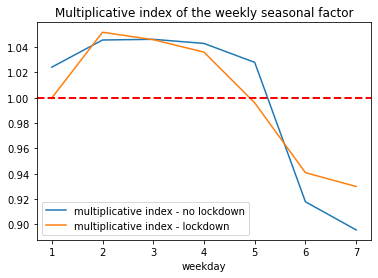

In [69]:
load_week_no_lockdown = fulldf[:n_training][fulldf[:n_training]["Lockdown"]==0].groupby('weekday').agg({'value':'mean'})
index_load_week_no_lockdown = load_week_no_lockdown / load_week_no_lockdown.mean()

load_week_lockdown = fulldf[:n_training][fulldf[:n_training]["Lockdown"]==1].groupby('weekday').agg({'value':'mean'})
index_load_week_lockdown = load_week_lockdown / load_week_lockdown.mean()

plt.plot(index_load_week_no_lockdown, label = 'multiplicative index - no lockdown')
plt.plot(index_load_week_lockdown, label = 'multiplicative index - lockdown')
plt.title('Multiplicative index of the weekly seasonal factor')
plt.axhline(1, color = 'red', linestyle="--",  linewidth = 2)
plt.xlabel('weekday')
plt.legend()

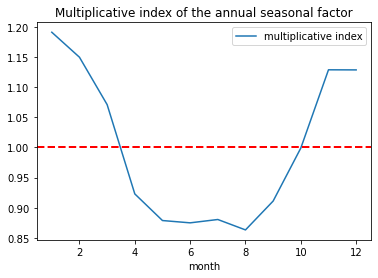

In [71]:
load_month = fulldf[:n_training].groupby('month').agg({'value':'mean'})
index_load_month = load_month / load_month.mean()

plt.plot(index_load_month, label = 'multiplicative index')
plt.title('Multiplicative index of the annual seasonal factor')
plt.axhline(1, color = 'red', linestyle="--",  linewidth = 2)
plt.xlabel('month')
plt.legend()

In [73]:
#we add the two multiplicative index to the fulldf dataset
index_load_week_no_lockdown.columns = ['weekly_multiplicative_index_no_lockdown']
index_load_week_no_lockdown = index_load_week_no_lockdown.reset_index()
index_load_week_lockdown.columns = ['weekly_multiplicative_index_lockdown']
index_load_week_lockdown = index_load_week_lockdown.reset_index()

index_load_month.columns = ['annual_multiplicative_index']
index_load_month = index_load_month.reset_index()

lost_index = fulldf.index
fulldf = fulldf.merge(index_load_week_no_lockdown, how = 'left', on = 'weekday')
fulldf = fulldf.merge(index_load_week_lockdown, how = 'left', on = 'weekday')
fulldf['weekly_multiplicative_index']=0
fulldf.weekly_multiplicative_index[fulldf['Lockdown']==0]=fulldf.weekly_multiplicative_index_no_lockdown[fulldf['Lockdown']==0]
fulldf.weekly_multiplicative_index[fulldf['Lockdown']==1]=fulldf.weekly_multiplicative_index_lockdown[fulldf['Lockdown']==1]
fulldf = fulldf.merge(index_load_month, how = 'left', on = 'month')
fulldf.index = lost_index
#drop weekday and month 
fulldf = fulldf.drop(columns = ['weekly_multiplicative_index_no_lockdown','weekly_multiplicative_index_lockdown'])

<ipython-input-73-699bc6fe08f7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fulldf.weekly_multiplicative_index[fulldf['Lockdown']==0]=fulldf.weekly_multiplicative_index_no_lockdown[fulldf['Lockdown']==0]
<ipython-input-73-699bc6fe08f7>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fulldf.weekly_multiplicative_index[fulldf['Lockdown']==1]=fulldf.weekly_multiplicative_index_lockdown[fulldf['Lockdown']==1]


# 4. Regression



In [75]:
#Function to plot the real and predicted outcome
def plot_regressor_results(real, prediction):
    figure(figsize=(15,8))
    plt.plot(real, label='real')
    plt.plot(prediction, label='predicted')
    plt.legend()
    plt.show()

In [77]:
#Copy of the full dataframe not to mess with the original
fulldf_copy = fulldf.copy()
regressordf = fulldf_copy[:-2]

### Basic regressor

With all the features

In [79]:
features_regressor = ['avg_temp','avg_sun','stringency_index']
target_column = ['value']

#Add features to the list of features that will be used for the training of the regressor
for t in range(1,31):
    features_regressor.append("values-" + str(t))

#Add features to the list of features that will be used for the training of the regressor
for t in [7, 14, 30]:
    features_regressor.append("moving_average_" + str(t))
    features_regressor.append("moving_average_stdev_" + str(t))
    features_regressor.append("moving_average_min_" + str(t))
    features_regressor.append("moving_average_max_" + str(t))

    
features_regressor = features_regressor + months.columns.values.tolist() + days.columns.values.tolist()
#target = fulldf[features].iloc[-1]

#Drop some of the columns 
df_regressor_final = regressordf[features_regressor + target_column].dropna()
nobs= len(df_regressor_final)
df_regressor_final.tail()

,avg_temp,avg_sun,stringency_index,values-1,values-2,values-3,values-4,values-5,values-6,values-7,...,month_10,month_11,month_12,day_2,day_3,day_4,day_5,day_6,day_7,value
2021-03-14,6.712569,221.219033,87.96,24311.125000,26368.666016,26548.562500,28595.478516,28685.333984,29934.541016,27075.103516,...,0,0,0,0,0,0,0,0,1,24831.708984
2021-03-15,9.129141,342.105667,87.96,24831.708984,24311.125000,26368.666016,26548.562500,28595.478516,28685.333984,29934.541016,...,0,0,0,0,0,0,0,0,0,28307.875000
2021-03-16,10.845864,385.937177,87.96,28307.875000,24831.708984,24311.125000,26368.666016,26548.562500,28595.478516,28685.333984,...,0,0,0,1,0,0,0,0,0,28139.875000
2021-03-17,7.248177,305.197977,87.96,28139.875000,28307.875000,24831.708984,24311.125000,26368.666016,26548.562500,28595.478516,...,0,0,0,0,1,0,0,0,0,28698.062500
2021-03-18,7.504540,82.955832,87.96,28698.062500,28139.875000,28307.875000,24831.708984,24311.125000,26368.666016,26548.562500,...,0,0,0,0,0,1,0,0,0,29149.291016


Total number of observations:  1508
Train: (1206, 62)(1206, 1), 
Test: (302, 62)(302, 1)
Train RMSE: 952.2931860604101
Test RMSE: 1550.9040156984777


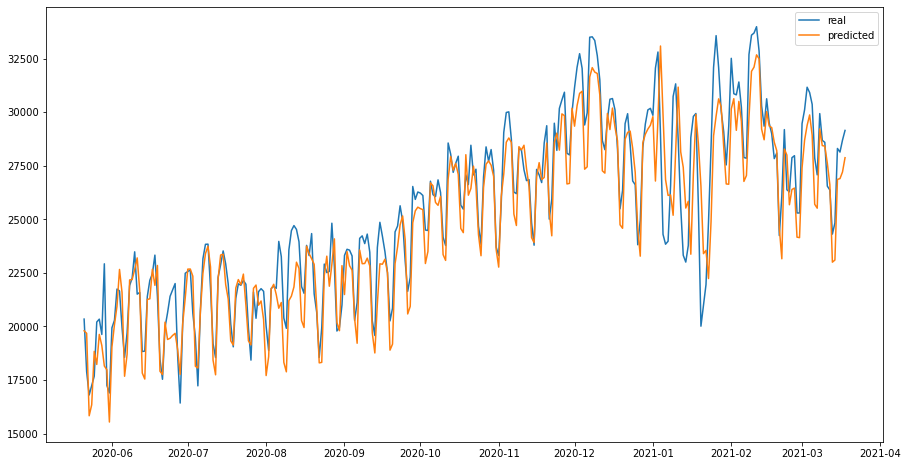

In [82]:
train_proportion = 0.8
train_idx = int(len(df_regressor_final)*train_proportion)

X_train = df_regressor_final[:train_idx][features_regressor]
y_train = df_regressor_final[:train_idx][target_column]

X_test = df_regressor_final[train_idx:][features_regressor]
y_test = df_regressor_final[train_idx:][target_column]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,X_test.shape, y_test.shape))

reg = LinearRegression().fit(X_train, y_train)
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test))

rslt = y_test
rslt['predicted'] = p_test

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test))

plot_regressor_results(rslt['value'],rslt['predicted'])
 
#prediction = reg.predict(np.array(target).reshape(1, -1))
#unscaled_prediction = prediction

In [84]:
results = sm.OLS(y_train, X_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  value   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.449e+04
Date:                Sun, 21 Mar 2021   Prob (F-statistic):                        0.00
Time:                        23:20:56   Log-Likelihood:                         -10042.
No. Observations:                1206   AIC:                                  2.020e+04
Df Residuals:                    1147   BIC:                                  2.050e+04
Df Model:                          59                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
avg_temp                 -107.4170     12.320     -8.719      0.000    -131.590     -83.244
avg_sun                    -1.3831      0.151     -9.131      0.000      -1.680      -1.086
stringency_index            1.8318      2.278      0.804      0.421      -2.638       6.301
values-1                    0.6356      0.031     20.685      0.000       0.575       0.696
values-2                   -0.0475      0.036     -1.320      0.187      -0.118       0.023
values-3                    0.0688      0.036      1.906      0.057      -0.002       0.140
values-4                   -0.0030      0.036     -0.082      0.935      -0.074       0.068
values-5                   -0.0391      0.036     -1.083      0.279      -0.110       0.032
values-6                    0.0809      0.036      2.251      0.025       0.010       0.151
values-7                    0.0402      0.037      1.095      0.274      -0.032       0.112
values-8                   -0.1015      0.035     -2.910      0.004      -0.170      -0.033
values-9                    0.0216      0.035      0.612      0.541      -0.048       0.091
values-10                  -0.0104      0.035     -0.297      0.767      -0.079       0.058
values-11                   0.0663      0.035      1.897      0.058      -0.002       0.135
values-12                  -0.0034      0.035     -0.097      0.923      -0.072       0.066
values-13                  -0.0072      0.035     -0.206      0.837      -0.076       0.061
values-14                   0.1171      0.035      3.341      0.001       0.048       0.186
values-15                  -0.0613      0.035     -1.771      0.077      -0.129       0.007
values-16                  -0.0413      0.035     -1.192      0.234      -0.109       0.027
values-17                   0.0781      0.035      2.257      0.024       0.010       0.146
values-18                  -0.0234      0.035     -0.671      0.503      -0.092       0.045
values-19                   0.0986      0.035      2.834      0.005       0.030       0.167
values-20                  -0.1109      0.035     -3.193      0.001      -0.179      -0.043
values-21                   0.1043      0.035      2.995      0.003       0.036       0.173
values-22                  -0.0357      0.035     -1.021      0.307      -0.104       0.033
values-23                  -0.0310      0.035     -0.885      0.376      -0.100       0.038
values-24                   0.0244      0.035      0.695      0.487      -0.044       0.093
values-25                   0.0068      0.035      0.194      0.846      -0.062       0.076
values-26                   0.0258      0.035      0.737      0.461      -0.043       0.094
values-27                   0.0169      

### Regressor omitting the insignificant variables



In [86]:
def remove_features(regression_results, p_value, *bypass_strings):
    features_to_remove = []
    for var_name, var in regression_results.items():
        bypass = False
        if var > p_value:
            for bp in bypass_strings:
                if bp in var_name:
                    bypass = True
            if bypass == False:
                print('Removing ',var_name)
                features_to_remove.append(var_name)
    return features_to_remove

In [88]:
features_to_remove = remove_features(results.pvalues, 0.05, 'day', 'month')

Removing  stringency_index
Removing  values-2
Removing  values-3
Removing  values-4
Removing  values-5
Removing  values-7
Removing  values-9
Removing  values-10
Removing  values-11
Removing  values-12
Removing  values-13
Removing  values-15
Removing  values-16
Removing  values-18
Removing  values-22
Removing  values-23
Removing  values-24
Removing  values-25
Removing  values-26
Removing  values-27
Removing  values-28
Removing  values-29
Removing  values-30
Removing  moving_average_stdev_7
Removing  moving_average_min_7
Removing  moving_average_max_7
Removing  moving_average_stdev_14
Removing  moving_average_max_14
Removing  moving_average_min_30


In [90]:
features_regressor_filtered = features_regressor

for feat in features_to_remove:
    try:
        features_regressor_filtered.remove(feat)
    except:
        pass
#features_regressor_filtered

In [92]:
df_regressor_final_filtered = regressordf[features_regressor_filtered + target_column].dropna()
nobs= len(df_regressor_final_filtered)
df_regressor_final_filtered

,avg_temp,avg_sun,values-1,values-6,values-8,values-14,values-17,values-19,values-20,values-21,...,month_10,month_11,month_12,day_2,day_3,day_4,day_5,day_6,day_7,value
2017-01-31,7.758482,0.000000,35173.042969,36131.042969,36784.167969,35871.980469,31961.187500,35262.750000,32682.791016,34039.042969,...,0,0,0,1,0,0,0,0,0,35037.937500
2017-02-01,9.169436,163.163000,35037.937500,37274.105469,35951.500000,36255.894531,31350.625000,34623.937500,35262.750000,32682.791016,...,0,0,0,0,1,0,0,0,0,33851.167969
2017-02-02,10.096927,30.851067,33851.167969,36871.605469,36131.042969,36207.582031,35477.812500,31961.187500,34623.937500,35262.750000,...,0,0,0,0,0,1,0,0,0,32107.312500
2017-02-03,8.435111,52.977833,32107.312500,31496.312500,37274.105469,35215.667969,35871.980469,31350.625000,31961.187500,34623.937500,...,0,0,0,0,0,0,1,0,0,32066.041016
2017-02-04,5.599032,191.990600,32066.041016,31548.228516,36871.605469,32867.667969,36255.894531,35477.812500,31350.625000,31961.187500,...,0,0,0,0,0,0,0,1,0,30181.521484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-14,6.712569,221.219033,24311.125000,29934.541016,27862.083984,25294.750000,27877.937500,26380.062500,29187.853516,26082.500000,...,0,0,0,0,0,0,0,0,1,24831.708984
2021-03-15,9.129141,342.105667,24831.708984,28685.333984,27075.103516,29467.750000,27969.896484,26284.166016,26380.062500,29187.853516,...,0,0,0,0,0,0,0,0,0,28307.875000
2021-03-16,10.845864,385.937177,28307.875000,28595.478516,29934.541016,30112.625000,25298.541016,27877.937500,26284.166016,26380.062500,...,0,0,0,1,0,0,0,0,0,28139.875000
2021-03-17,7.248177,305.197977,28139.875000,26548.562500,28685.333984,31165.583984,25294.750000,27969.896484,27877.937500,26284.166016,...,0,0,0,0,1,0,0,0,0,28698.062500


Total number of observations:  1508
Train: (1206, 33)(1206, 1), 
Test: (302, 33)(302, 1)
Train RMSE: 976.144393834274
Test RMSE: 1465.0772079837484
Execution time: 0.011912107467651367
MAPE: 4.161368639451992


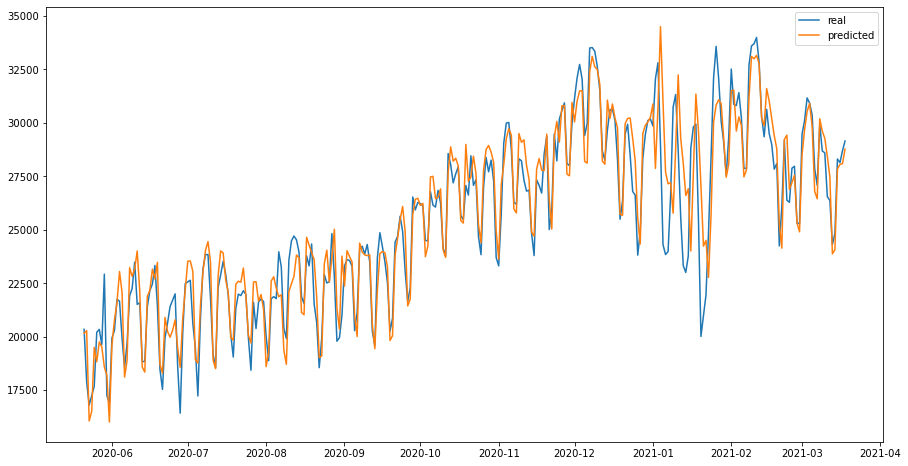

In [94]:
train_proportion = 0.8
train_idx = int(len(df_regressor_final_filtered)*train_proportion)

X_train = df_regressor_final[:train_idx][features_regressor_filtered]
y_train = df_regressor_final[:train_idx][target_column]

X_test = df_regressor_final[train_idx:][features_regressor_filtered]
y_test = df_regressor_final[train_idx:][target_column]

n, k = X_train.shape
print("Total number of observations: ", nobs)
print("Train: {}{}, \nTest: {}{}".format(X_train.shape, y_train.shape,X_test.shape, y_test.shape))
startTime = time.time()
reg = LinearRegression().fit(X_train, y_train)
executionTime = (time.time() - startTime)
p_train = reg.predict(X_train)
p_test = reg.predict(X_test)

RMSE_train = np.sqrt(mean_squared_error(y_train, p_train))
RMSE_test = np.sqrt(mean_squared_error(y_test, p_test))
MAPE=mean_absolute_percentage_error(y_test, p_test)

rslt = y_test
rslt['predicted'] = p_test

print("Train RMSE: {}\nTest RMSE: {}".format(RMSE_train, RMSE_test))

print('Execution time:', executionTime)
print('MAPE:',MAPE)

plot_regressor_results(rslt['value'],rslt['predicted'])

### Regressor value predictor

In [96]:
df_prediction_regressor_iter1_raw = fulldf_copy[:-2]

In [97]:
#The previous regressor code has had to run for this nor to crash
#The reason is that we need the variables features_regressor_filtered and target_column defined
#The features_regressor_filtered could be changed for features_regressor to include the whole features
df_prediction_regressor_iter1 = df_prediction_regressor_iter1_raw[features_regressor_filtered + target_column].dropna()

In [98]:
train_proportion = 0.8
train_idx = int(len(df_prediction_regressor_iter1)*train_proportion)

X_train = df_regressor_final[:train_idx][features_regressor_filtered]
y_train = df_regressor_final[:train_idx][target_column]

X_test = df_regressor_final[train_idx:][features_regressor_filtered]
y_test = df_regressor_final[train_idx:][target_column]

reg = LinearRegression().fit(X_train, y_train)


In [99]:
pretarget = fulldf_copy.iloc[-2][features_regressor_filtered]
prediction = reg.predict(np.array(pretarget).reshape(1, -1))
float(prediction)

28608.063697706082

In [100]:
last_minus_one_index = str(fulldf_copy.index[-2]).split(' ')[0]
fulldf_copy.at[last_minus_one_index, 'value'] = float(prediction)

In [101]:
#add moving average for three days 
#add lag values
for t in range(1,31):
    fulldf_copy["values-" + str(t)] = fulldf_copy.value.shift(periods=t)

for t in [7, 14, 30]:
    fulldf_copy[["moving_average_" + str(t), "moving_average_stdev_" + str(t), "moving_average_min_" + str(t) ,"moving_average_max_" + str(t)]] = fulldf_copy.value.rolling(t).agg([np.mean, np.std, np.max, np.min]).shift(1)

#creating quadratic term 
fulldf_copy["quadratic"] = fulldf_copy["values-1"]**2

In [102]:
df_prediction_regressor_final = fulldf_copy[features_regressor_filtered + target_column].dropna()

In [103]:
target = df_prediction_regressor_final.iloc[-1][features_regressor_filtered]

In [80]:
prediction = float(reg.predict(np.array(target).reshape(1, -1)))
sdv = np.std(np.array(y_test)-np.array(p_test))

print('forecast: {}, standard deviation: {}'.format(prediction, sdv))

log_value = math.log(prediction)
log_stdv = math.log(prediction+sdv)-log_value

print('forecast in logarithmic form: {}, standard deviation in logarithmic form: {}'.format(log_value, log_stdv))

forecast: 26200.061880821897, standard deviation: 1029.3498723430016
forecast in logarithmic form: 10.17351705160983, standard deviation in logarithmic form: 0.038535930929473494


## 5.1 Neural network 

neural network model  (https://towardsdatascience.com/predicting-sales-611cb5a252de) 

In [127]:
# cols=list(fulldf.columns)
# #removing the dummys for day and month (leaving the weekday and month variables)
# #for elem in list(cols):
# #    if 'day_' in elem:
# #        cols.remove(elem)
# #    if 'month_' in elem:
# #        cols.remove(elem)
# cols.remove('weekday')
# cols.remove('month')
# cols_1=[]
# RMSE_1=4000
# RMSE=3000
# while cols!=['value'] and cols_1!=cols  and RMSE_1>RMSE:
#     #select the columns we wanna have
    
#     df_adjusted=fulldf.loc[:,cols]
#     #remove first 30 values of dataframe since it includes NaN
#     df_adjusted = df_adjusted.iloc[30:-2]

#     #split dataset
#     X_train_1, X_test_1, y_train, y_test = train_test_split(df_adjusted.drop(columns=["value"]),df_adjusted.value, test_size = 0.2, shuffle=False)
#     scaler_x = preprocessing.MinMaxScaler()
#     X_train=scaler_x.fit_transform(X_train_1.values)
#     X_test=scaler_x.transform(X_test_1.values)

#     X_train = pd.DataFrame(X_train, columns=X_train_1.columns, index=X_train_1.index)
#     X_test = pd.DataFrame(X_test, columns=X_train_1.columns, index=X_test_1.index)

#     #run neural network model 
#     regr = MLPRegressor(hidden_layer_sizes = (112), random_state=1, max_iter=10000).fit(X_train, y_train)

#     #get the full test set performance 
#     nn_pred_full = regr.predict(X_test)
#     nn_pred_full=pd.Series(nn_pred_full, index=X_test.index)

#     #we renormalize the target values
#     pred=nn_pred_full[:-3]
#     actual=y_test[:-3]

#     RMSE_1=RMSE

#     #accuracy of the model 
#     MSE = mean_squared_error(pred, actual)
#     RMSE = math.sqrt(MSE)

#     MAPE=mean_absolute_percentage_error(pred, actual)

#     print("RMSE:",RMSE)
#     print('MAPE:',MAPE)

#     perm = PermutationImportance(regr, random_state=1).fit(X_test, y_test)
#     w=eli5.explain_weights_df(perm,top=None,feature_names=X_test.columns.tolist())
#     print(w)

#     cols_1=cols
#     cols=['value']
#     for i in range(len(w)):
#         if w.loc[i,'weight']>0:
#             cols.append(w.loc[i,'feature'])

#     print(cols)
# print(cols)

RMSE: 2400.8822916052904
MAPE: 5.958011124445488
                        feature    weight       std
0                       month_8  0.259874  0.016935
1                       month_6  0.253132  0.025332
2                       month_7  0.243130  0.013975
3   weekly_multiplicative_index  0.236987  0.025480
4                       month_9  0.235301  0.016894
..                          ...       ...       ...
71                    values-20 -0.014262  0.002317
72                     values-4 -0.014744  0.003836
73                    values-11 -0.015195  0.002274
74                     values-3 -0.018667  0.005270
75                    values-19 -0.019535  0.002122

[76 rows x 3 columns]
['value', 'month_8', 'month_6', 'month_7', 'weekly_multiplicative_index', 'month_9', 'month_10', 'month_5', 'moving_average_min_30', 'month_2', 'values-1', 'quadratic', 'day_7', 'values-8', 'values-29', 'month_11', 'values-22', 'day_5', 'day_6', 'values-9', 'dayoff', 'Leeds_temp', 'Bristol_temp', 'value

In [120]:
#select the columns we wanna have
#cols=['avg_weight_temp','avg_weight_sun','value','moving_average_7','values-1','values-2','values-3','values-7','values-14','values-30','values-4','values-5','values-6','quadratic','weekly_multiplicative_index','annual_multiplicative_index']
cols=['avg_temp', 'avg_sun', 'values-1', 'values-6', 'values-8', 'values-14','values-17','values-19','values-20', 'values-21', 'moving_average_7', 'moving_average_14','moving_average_min_14', 'moving_average_30','moving_average_stdev_30','moving_average_max_30','month_2','month_3','month_4','month_5','month_6','month_7','month_8','month_9','month_10','month_11','month_12','day_2','day_3','day_4','day_5','day_6','day_7','value']
df_adjusted=fulldf.loc[:,cols]
#remove first 30 values of dataframe since it includes NaN
df_adjusted = df_adjusted.iloc[30:-2]

In [121]:
#split dataset
X_train_1, X_test_1, y_train, y_test = train_test_split(df_adjusted.drop(columns=["value"]),df_adjusted.value, test_size = 0.2, shuffle=False)

scaler_x = preprocessing.MinMaxScaler()

X_train=scaler_x.fit_transform(X_train_1.values)
X_test=scaler_x.transform(X_test_1.values)

X_train = pd.DataFrame(X_train, columns=X_train_1.columns, index=X_train_1.index)
X_test = pd.DataFrame(X_test, columns=X_train_1.columns, index=X_test_1.index)

#run neural network model 
startTime=time.time()
regr = MLPRegressor(hidden_layer_sizes = (112), random_state=1, max_iter=10000).fit(X_train, y_train)
executionTime=(time.time()-startTime)

RMSE: 1627.5181599493137
Std: 1590.588516515911
Execution time: 51.9543080329895
MAPE: 4.690439110087596


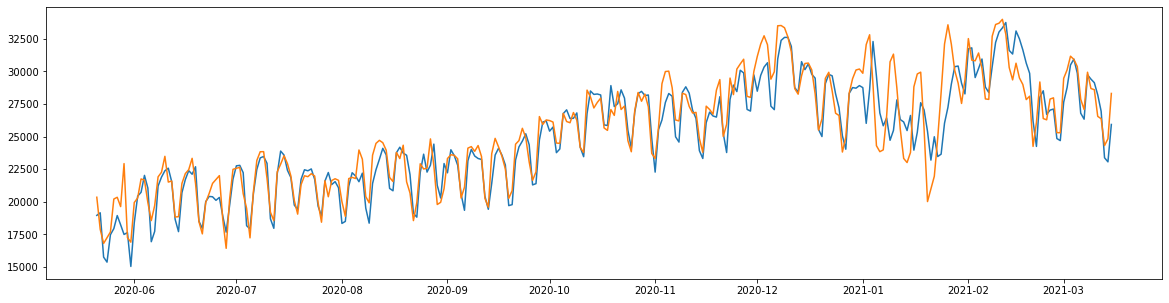

In [122]:
#get the full test set performance 
nn_pred_full = regr.predict(X_test)
nn_pred_full=pd.Series(nn_pred_full, index=X_test.index)

#we renormalize the target values
pred=nn_pred_full[:-3]
log_pred = np.array([math.log(i) if i>0 else 0 for i in pred])

actual=y_test[:-3]
log_actual = np.array([math.log(i) if i>0 else 0 for i in actual])

#accuracy of the model 
MSE = mean_squared_error(pred, actual)
RMSE = math.sqrt(MSE)

MAPE=mean_absolute_percentage_error(pred, actual)
log_MSE = mean_squared_error(log_pred, log_actual)
log_RMSE = math.sqrt(log_MSE)

st_devNN=np.std(pred-actual)

print("RMSE:",RMSE)
print("Std:",st_devNN)
print('Execution time:', executionTime)
print('MAPE:',MAPE)

#plot real values 
plt.figure(figsize = (20,5))
plt.plot(pred)
plt.plot(actual)

## 5.2 Recurring Neural net - Long Short Term Memory 

RNN LSTM from (https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/12.time-series-demand_prediction.ipynb ) 

1206 302
Epoch 1/50
30/30 [==============================] - 5s 50ms/step - loss: 0.0825 - val_loss: 0.0316
Epoch 2/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0247 - val_loss: 0.0179
Epoch 3/50
30/30 [==============================] - 1s 20ms/step - loss: 0.0167 - val_loss: 0.0167
Epoch 4/50
30/30 [==============================] - 1s 21ms/step - loss: 0.0172 - val_loss: 0.0149
Epoch 5/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0143 - val_loss: 0.0131
Epoch 6/50
30/30 [==============================] - 1s 17ms/step - loss: 0.0133 - val_loss: 0.0114
Epoch 7/50
30/30 [==============================] - 1s 19ms/step - loss: 0.0122 - val_loss: 0.0101
Epoch 8/50
30/30 [==============================] - 1s 21ms/step - loss: 0.0102 - val_loss: 0.0090
Epoch 9/50
30/30 [==============================] - 1s 21ms/step - loss: 0.0095 - val_loss: 0.0085
Epoch 10/50
30/30 [==============================] - 1s 18ms/step - loss: 0.0090 - val_loss: 0.0080


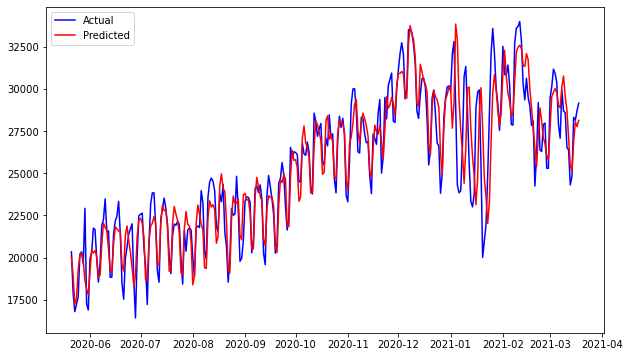

Root Mean Square Error: 1681.227230329083
Std: 5701.979
Log std: 0.06521274803143245
Execution time: 31.6794331073761
MAPE: 18.932487070560455


In [125]:
#Selecting the columns we want, 'value' need to be first I think
# no lag value because the model implements that already
cols=['value','avg_weight_temp','weekly_multiplicative_index','quadratic']
#cols=['value','avg_temp', 'avg_sun', 'moving_average_7', 'moving_average_14','moving_average_min_14', 'moving_average_30','moving_average_stdev_30','moving_average_max_30']
df=fulldf.loc[:,cols]
df= df.iloc[30:-2]

#Split dataset into training and test at 90% 
train_size = int(len(df) * 0.80)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

X_train = []
y_train = []
time_steps=20

x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

train_X = x_scaler.fit_transform(train.drop(columns=['value']))
train_y = y_scaler.fit_transform(train[['value']])
train_s=pd.DataFrame(train_X, columns=cols[1:], index=train.index)
train_s['value']=train_y

for i in range(time_steps, len(train)):
    X_train.append(train_s[i-time_steps:i].values) #lag all the columns of the dataset up to the current date
    y_train.append(train_s[i:i+1].value.values) #keep the value for the current date
X_train,y_train=np.array(X_train), np.array(y_train)
X_train= np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

startTime=time.time()

model = keras.Sequential()
model.add(
  keras.layers.Bidirectional(
    keras.layers.LSTM(
      units=128, 
      input_shape=(X_train.shape[1],X_train.shape[2])
    )
  )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit sequential LSTM to data  
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    batch_size=32, 
    validation_split=0.2,
    shuffle=False
)
executionTime=(time.time()-startTime)

test_inputs = df[len(df) - len(test) - time_steps:]

test_X = x_scaler.fit_transform(test_inputs.drop(columns=['value']))
test_y = y_scaler.fit_transform(test_inputs[['value']])
test_s=pd.DataFrame(test_X, columns=cols[1:], index=test_inputs.index)
test_s['value']=test_y

test_features = []
for i in range(time_steps, time_steps+len(test)):
    test_features.append(test_s[i-time_steps:i].values)

test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], test_features.shape[2]))

predictions = model.predict(test_features)
predictions = y_scaler.inverse_transform(predictions)

plt.figure(figsize=(10,6))
plt.plot(test.value, color='blue', label='Actual')
plt.plot(test.index,predictions , color='red', label='Predicted')
plt.legend()
plt.show()

#display accuracy of the model 
MSE = mean_squared_error(predictions, test.value)
RMSE = math.sqrt(MSE)
MAPE=mean_absolute_percentage_error(predictions, test.value)

st_dev_LTSM=np.std(predictions-test.value.values)
log_pred = np.array([math.log(i) if i>0 else 0 for i in predictions])
log_actual = np.array([math.log(i) if i>0 else 0 for i in test.value.values])

log_stdv_LTSM =np.std(log_pred-log_actual)

print("Root Mean Square Error:",RMSE)
print("Std:",st_dev_LTSM)
print("Log std:",log_stdv_LTSM)
print('Execution time:', executionTime)
print('MAPE:',MAPE)

# 5.3. Making Prediction

In [35]:
a = np.array([28])
b = np.array([28])
np.concatenate((a,b))

array([28, 28])

In [36]:
def get_two_last_values_NN_LR(df_adjusted, model, col_to_select, date_prediction, scaler):
    
    #we drop some columns depending of the model 
    #df = df_adjusted.drop(columns = col_to_supress)

    #we select the columns we want for this model
    df=df_adjusted.loc[:,col_to_select]
    
    #we train on the whole dataset minus the 2 last rows
    X_train_1, y_train = df.drop(columns=["value"])[30:-2], df.value[30:-2]  
    X_test_1 = df.drop(columns=["value"])[-2:]

    #we scale the date
    X_train = scaler.fit_transform(X_train_1.values)
    X_test = scaler.transform(X_test_1.values)
    X_train = pd.DataFrame(X_train, columns=X_train_1.columns, index=X_train_1.index)
    X_test = pd.DataFrame(X_test, columns=X_test_1.columns, index=X_test_1.index)

#------------------------------------------------------
    if model == 'NN':
        mod = MLPRegressor(hidden_layer_sizes = (112), random_state=1, max_iter=10000).fit(X_train, y_train)
        mod.fit(X_train, y_train)
     
    
    elif model == 'Linear':
        mod = LinearRegression()
        mod.fit(X_train, y_train)
        
#----------------------------------------------------------        
           
    #get the first forecast
    pred1 = mod.predict(X_test[-2:-1])
    #put it inside the last row in the initial df X_test_1
    X_test_1.loc[date_prediction, 'values-1'] = pred1 
    
    #ATTENTION: some other columns must be completed (like moving average, quadratic), code to put here
    X_test_1.loc[date_prediction, 'quadratic'] = pred1**2
    X_test_1.loc[date_prediction, 'moving_average_7'] = X_test_1['moving_average_7'].iloc[-2]
    
    #rescaling the data
    X_test = scaler.transform(X_test_1.values)
    X_test = pd.DataFrame(X_test, columns=X_test_1.columns, index=X_test_1.index)

    #get the last forecast
    pred2 = mod.predict(X_test[-1:])
    X_test_1['value'] = np.concatenate((pred1, pred2))
        
    return X_test_1

In [37]:
def get_two_last_values_LSTM(df_adjusted, col_to_select, date_prediction):
    #we select the columns we want for this model
    df=df_adjusted.loc[:,col_to_select]
    time_steps=20
    df= df.iloc[time_steps:]
    #we train on the whole dataset minus the 2 last rows
    train, test = df.iloc[:-2], df.iloc[-2]
    X_train = []
    y_train = []

    x_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    train_X = x_scaler.fit_transform(train.drop(columns=['value']))
    train_y = y_scaler.fit_transform(train[['value']])
    train_s=pd.DataFrame(train_X, columns=cols[1:], index=train.index)
    train_s['value']=train_y

    for i in range(time_steps, len(train)):
        X_train.append(train_s[i-time_steps:i].values) #lag all the columns of the dataset up to the current date
        y_train.append(train_s[i:i+1].value.values) #keep the value for the current date
    X_train,y_train=np.array(X_train), np.array(y_train)
    X_train= np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))


    model = keras.Sequential()
    model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
        units=128, 
        input_shape=(X_train.shape[1],X_train.shape[2])
        )
    )
    )
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # fit sequential LSTM to data  
    history = model.fit(
        X_train, y_train, 
        epochs=50, 
        batch_size=32, 
        validation_split=0.1,
        shuffle=False
    )


    #selecting up from -21 data up to -1 data 
    test_inputs = df[len(df) - 2 - time_steps:-1]
    test_X = x_scaler.fit_transform(test_inputs.drop(columns=['value']))
    test_y = y_scaler.fit_transform(test_inputs[['value']])
    test_s=pd.DataFrame(test_X, columns=cols[1:], index=test_inputs.index)
    test_s['value']=test_y

    test_features = []
    for i in range(time_steps, time_steps+1):
        test_features.append(test_s[i-time_steps:i].values)

    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], test_features.shape[2]))

    predictions = model.predict(test_features)
    predictions = y_scaler.inverse_transform(predictions)


    #put it inside the last row of df
    df.loc[date_prediction,'value']=predictions[0][0]
    
    #ATTENTION: some other columns must be completed 
    df.loc[date_prediction, 'quadratic'] = predictions[0][0]**2
    
    #repreparing the new test set
    test = df.iloc[-1]
    test_inputs = df[len(df) - 1 - time_steps:]

    test_X = x_scaler.fit_transform(test_inputs.drop(columns=['value']))
    test_y = y_scaler.fit_transform(test_inputs[['value']])
    test_s=pd.DataFrame(test_X, columns=cols[1:], index=test_inputs.index)
    test_s['value']=test_y

    test_features = []
    for i in range(time_steps, time_steps+1):
        test_features.append(test_s[i-time_steps:i].values)

    test_features = np.array(test_features)
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], test_features.shape[2]))

    predictions = model.predict(test_features)
    predictions = y_scaler.inverse_transform(predictions)
        
    return predictions

In [38]:
#arguments
df_adjusted = fulldf.copy()
model = 'NN'
col_to_select =['avg_weight_temp','avg_weight_sun','value','moving_average_7','values-1','values-2','values-3','values-7','values-14','values-30','values-4','values-5','values-6','quadratic','weekly_multiplicative_index','annual_multiplicative_index']      #['moving_avg_lag1', 'quadratic']
date_prediction = '2021-03-20'  #if we are the 12th and we want to predict the 13th, we put the 13th
scaler = preprocessing.MinMaxScaler()

result = get_two_last_values_NN_LR(df_adjusted, model, col_to_select, date_prediction, scaler)

#you can read the result in the column value
print('The log of the value is:',math.log(result.loc['2021-03-20'].value))
print('The standard deviation of that log value is:',)

/Users/coralineduval/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(
The log of the value is: 10.165949109368519
The standard deviation of that log value is:
/Users/coralineduval/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [39]:
#arguments
df_adjusted = fulldf.copy()
model = 'LSTM'
col_to_select =['value','avg_weight_temp','weekly_multiplicative_index','quadratic']
date_prediction = '2021-03-20'  #if we are the 12th and we want to predict the 13th, we put the 13th

result = get_two_last_values_LSTM(df_adjusted, col_to_select, date_prediction)

#you can read the result in the column value
print('The log of the value is:',math.log(result))
print('The standard deviation is:',st_dev_LTSM)
print('The standard deviation of the log is:',log_stdv_LTSM)

Epoch 1/50
43/43 [==============================] - 4s 27ms/step - loss: 0.0622 - val_loss: 0.0194
Epoch 2/50
43/43 [==============================] - 1s 14ms/step - loss: 0.0156 - val_loss: 0.0182
Epoch 3/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0130 - val_loss: 0.0169
Epoch 4/50
43/43 [==============================] - 1s 16ms/step - loss: 0.0116 - val_loss: 0.0157
Epoch 5/50
43/43 [==============================] - 1s 17ms/step - loss: 0.0110 - val_loss: 0.0208
Epoch 6/50
43/43 [==============================] - 1s 19ms/step - loss: 0.0090 - val_loss: 0.0182
Epoch 7/50
43/43 [==============================] - 1s 16ms/step - loss: 0.0078 - val_loss: 0.0177
Epoch 8/50
43/43 [==============================] - 1s 15ms/step - loss: 0.0069 - val_loss: 0.0167
Epoch 9/50
43/43 [==============================] - 1s 16ms/step - loss: 0.0065 - val_loss: 0.0161
Epoch 10/50
43/43 [==============================] - 1s 18ms/step - loss: 0.0068 - val_loss: 0.0160
Epoch 11/

# Appendix 

Useful links: 
- Neural network for short term load forecasting( https://github.com/lbenning/Load-Forecasting/blob/master/src/neural.py ) 
- pdf with short term load forecasting (https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwj8z9XJtarvAhWStHEKHWv_AtoQFjABegQIAhAD&url=https%3A%2F%2Fwww.mdpi.com%2F1996-1073%2F11%2F12%2F3493%2Fpdf&usg=AOvVaw3nQltZKyxmiaS1nPBofhf6 ) 
- ( https://www.researchgate.net/publication/335664014_Energy_load_forecasting_model_based_on_deep_neural_networks_for_smart_grids/link/5d758e9ba6fdcc9961ba50c0/download ) 
- (https://towardsdatascience.com/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python-1d1076fc89a0#_=_) 
- Gonna try this: https://curiousily.com/posts/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python/
- Code version ( https://github.com/curiousily/Deep-Learning-For-Hackers/blob/master/12.time-series-demand_prediction.ipynb ) 
- 

# Code testing 